In [1]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('iris.data', index_col = None, header = None)
df.columns = ['x1','x2','x3','x4','y']
df = df.iloc[50:150]
df['y'] = df['y'].apply(lambda x: 0 if x == 'Iris-versicolor' else 1)
df.tail()

,x1,x2,x3,x4,y
145,6.7,3.0,5.2,2.3,1
146,6.3,2.5,5.0,1.9,1
147,6.5,3.0,5.2,2.0,1
148,6.2,3.4,5.4,2.3,1
149,5.9,3.0,5.1,1.8,1


In [3]:
X = torch.tensor(df[['x2','x3']].values, dtype = torch.float)
y = torch.tensor(df['y'].values, dtype = torch.int)

torch.manual_seed(123)
shuffle_idx = torch.randperm(y.size(0), dtype = torch.long)

X,y = X[shuffle_idx], y[shuffle_idx]

percent80 = int(shuffle_idx.size(0) * 0.8)

X_train, X_test = X[shuffle_idx[:percent80]], X[shuffle_idx[percent80:]]
y_train, y_test = y[shuffle_idx[:percent80]], y[shuffle_idx[percent80:]]

mu, std = X_train.mean(dim=0), X_train.std(dim = 0)
X_train = (X_train - mu) / std
X_test = (X_test - mu) / std

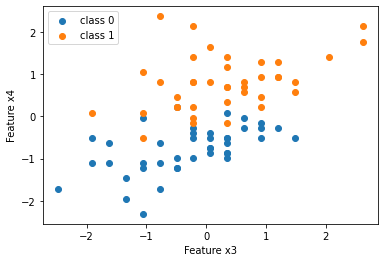

In [4]:
plt.scatter(X_train[y_train==0, 0], X_train[y_train == 0, 1], label='class 0')
plt.scatter(X_train[y_train == 1,0], X_train[y_train ==1, 1], label = 'class 1')
plt.xlabel('Feature x3')
plt.ylabel('Feature x4')
plt.legend()
plt.show()

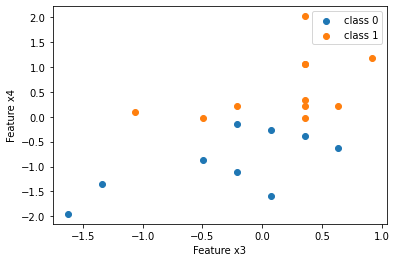

In [5]:
plt.scatter(X_test[y_test==0, 0], X_test[y_test == 0, 1], label='class 0')
plt.scatter(X_test[y_test == 1,0], X_test[y_test ==1, 1], label = 'class 1')
plt.xlabel('Feature x3')
plt.ylabel('Feature x4')
plt.legend()
plt.show()

In [6]:
class Adaline():
    def __init__(self,num_features):
        self.num_features = num_features
        self.weights = torch.zeros(num_features, 1, dtype = torch.float)
        self.bias = torch.zeros(1, dtype = torch.float)
        
    def forward(self, X):
        net_input = torch.add(torch.mm(X, self.weights), self.bias)
        activation = net_input
        return activation.view(-1)
    
    def backward(self, X, yhat, y):
        grad_loss_outer = 2 * (yhat - y)
        
        grad_weights_inner = X
        grad_bias_inner = 1
        
        grad_loss_weights = torch.mm(grad_weights_inner.t(), grad_loss_outer.view(-1,1)) / y.size(0)
        grad_loss_bias = torch.sum(grad_loss_outer) / y.size(0)
        
        return (-1)*grad_loss_weights, (-1)*grad_loss_bias

In [7]:
def MSE(yhat, y):
    return torch.mean((yhat - y) ** 2)

def train(model, X, y, epochs, learning_rate = 0.01, seed= 123, minibatch_size = 10):
    cost = []
    torch.manual_seed(seed)
    for i in range(epochs):
        
        shuffle_idx = torch.randperm(y.size(0),dtype = torch.long)
        minibatches = torch.split(shuffle_idx, minibatch_size)
        
        for j in minibatches:
            yhat = model.forward(X[j])
            
            neg_grad_weights, neg_grad_bias = model.backward(X[j], yhat, y[j])
            
            model.weights += learning_rate * (neg_grad_weights)
            model.bias += learning_rate * (neg_grad_bias)
            
            minibatch_loss = MSE(yhat, y[j])
            print("Minibatch MSE: %.3f" % minibatch_loss)
        
        yhat = model.forward(X)
        loss = MSE(yhat, y)
        print('Epoch: %03d' % (i+1), end="")
        print(' | MSE: %.5f' % loss)
        cost.append(loss)
    
    return cost

In [8]:
model = Adaline(num_features = X_train.size(1))

cost = train(model, X_train, y_train, epochs = 100, learning_rate = 0.1, seed = 123, minibatch_size = 10)

Minibatch MSE: 0.500
Minibatch MSE: 0.288
Minibatch MSE: 0.108
Minibatch MSE: 0.185
Minibatch MSE: 0.269
Minibatch MSE: 0.137
Minibatch MSE: 0.180
Minibatch MSE: 0.149
Epoch: 001 | MSE: 0.10482
Minibatch MSE: 0.082
Minibatch MSE: 0.058
Minibatch MSE: 0.097
Minibatch MSE: 0.064
Minibatch MSE: 0.117
Minibatch MSE: 0.164
Minibatch MSE: 0.067
Minibatch MSE: 0.134
Epoch: 002 | MSE: 0.09160
Minibatch MSE: 0.043
Minibatch MSE: 0.075
Minibatch MSE: 0.079
Minibatch MSE: 0.069
Minibatch MSE: 0.080
Minibatch MSE: 0.116
Minibatch MSE: 0.124
Minibatch MSE: 0.166
Epoch: 003 | MSE: 0.09018
Minibatch MSE: 0.099
Minibatch MSE: 0.043
Minibatch MSE: 0.065
Minibatch MSE: 0.111
Minibatch MSE: 0.106
Minibatch MSE: 0.129
Minibatch MSE: 0.078
Minibatch MSE: 0.100
Epoch: 004 | MSE: 0.08915
Minibatch MSE: 0.074
Minibatch MSE: 0.095
Minibatch MSE: 0.071
Minibatch MSE: 0.078
Minibatch MSE: 0.162
Minibatch MSE: 0.072
Minibatch MSE: 0.058
Minibatch MSE: 0.126
Epoch: 005 | MSE: 0.08938
Minibatch MSE: 0.136
Minibatch

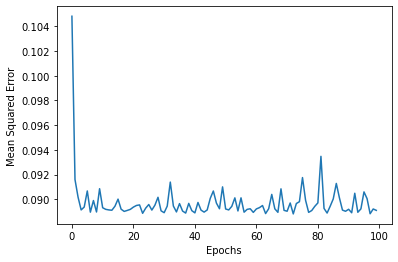

In [9]:
plt.plot(range(len(cost)), cost)
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error")
plt.show()

In [26]:
print('Weights', model.weights)
print('Bias', model.bias)

Weights tensor([[-0.0636],
        [ 0.4449]])
Bias tensor([0.4769])


In [27]:
def analytical_solution(x, y):
    Xb = torch.cat( (torch.ones((x.size(0), 1)), x), dim=1)
    w = torch.zeros(x.size(1))
    z = torch.inverse(torch.matmul(Xb.t(), Xb))
    params = torch.matmul(z, torch.matmul(Xb.t(), y))
    b, w = torch.tensor([params[0]]), params[1:].view(x.size(1), 1)
    return w, b

w, b = analytical_solution(X_train, y_train.float())
print('Analytical weights', w)
print('Analytical bias', b)

Analytical weights tensor([[-0.0692],
        [ 0.4348]])
Analytical bias tensor([0.4875])


In [28]:
ones = torch.ones(y_train.size())
zeros = torch.zeros(y_train.size())
train_pred = model.forward(X_train)
train_acc = torch.mean(
    (torch.where(train_pred > 0.5, 
                 ones, 
                 zeros).int() == y_train).float())

ones = torch.ones(y_test.size())
zeros = torch.zeros(y_test.size())
test_pred = model.forward(X_test)
test_acc = torch.mean(
    (torch.where(test_pred > 0.5, 
                 ones, 
                 zeros).int() == y_test).float())

print('Training Accuracy: %.2f' % (train_acc*100))
print('Test Accuracy: %.2f' % (test_acc*100))

Training Accuracy: 92.50
Test Accuracy: 90.00


/home/unique/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:171: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return array(a, dtype, copy=False, order=order, subok=True)
/home/unique/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


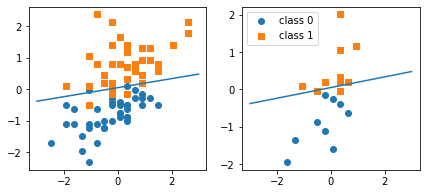

In [29]:
w, b = model.weights, model.bias - 0.5

x_min = -3
y_min = ( (-(w[0] * x_min) - b[0]) 
          / w[1] )

x_max = 3
y_max = ( (-(w[0] * x_max) - b[0]) 
          / w[1] )


fig, ax = plt.subplots(1, 2, sharex=True, figsize=(7, 3))

ax[0].plot([x_min, x_max], [y_min, y_max])
ax[1].plot([x_min, x_max], [y_min, y_max])

ax[0].scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], label='class 0', marker='o')
ax[0].scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], label='class 1', marker='s')

ax[1].scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], label='class 0', marker='o')
ax[1].scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], label='class 1', marker='s')

ax[1].legend(loc='upper left')
plt.show()